In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


h_X = pd.read_csv('data_clean/train_h_X_v1.csv')
h_y = pd.read_csv("data_clean/train_h_y.csv").to_numpy().ravel() # flatten

no_ads_X = pd.read_csv('data_clean/train_no_ads_X_v1.csv')
no_ads_y = pd.read_csv('data_clean/train_no_ads_y.csv').to_numpy().ravel()

print(h_X.shape)
print(h_y.shape)

print(no_ads_X.shape)
print(no_ads_y.shape)

(1411, 100)
(1411,)
(12774, 112)
(12774,)


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


h_X_train, h_X_test, h_y_train, h_y_test = train_test_split(
    h_X, 
    h_y, 
    test_size=0.2, 
    random_state=1065)

no_ads_X_train, no_ads_X_test, no_ads_y_train, no_ads_y_test = train_test_split(
    no_ads_X, 
    no_ads_y, 
    test_size=0.2, 
    random_state=1065)

h_scaler = StandardScaler()
no_ads_scaler = StandardScaler()

h_X_train_scaled = h_scaler.fit_transform(h_X_train)
h_X_test_scaled = h_scaler.transform(h_X_test)

no_ads_X_train_scaled = no_ads_scaler.fit_transform(no_ads_X_train)
no_ads_X_test_scaled = no_ads_scaler.fit_transform(no_ads_X_test)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils.fixes import parse_version


X_train, X_test, y_train, y_test = train_test_split(h_X, h_y, test_size=0.1, random_state=13)

print("Target variable stats:")
print(f"Mean: {y_train.mean():.2f}")
print(f"Std: {y_train.std():.2f}")
print(f"Min: {y_train.min():.2f}")
print(f"Max: {y_train.max():.2f}")
print(f"\nFeature matrix shape: {X_train.shape}")
# print(f"Any NaN values: {np.isnan(X_train).any() or np.isnan(y_train).any()}")

Target variable stats:
Mean: -483.11
Std: 227.24
Min: -1747.63
Max: -59.02

Feature matrix shape: (1269, 100)


In [52]:
params = {
    "n_estimators": 500,
    "max_depth": 3,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print(mse)

baseline_mse = mean_squared_error(y_test, np.full_like(y_test, y_train.mean()))
print(f"\nBaseline MSE (always predicting mean): {baseline_mse:.2f}")
print(f"Your model MSE: {mse:.2f}")
print(f"Improvement: {((baseline_mse - mse) / baseline_mse * 100):.1f}%")

31716.13340854124

Baseline MSE (always predicting mean): 61708.15
Your model MSE: 31716.13
Improvement: 48.6%


Model Performance Metrics:
Training R²: 0.5705
Test R²: 0.4834
Test RMSE: 178.09
Test MAE: 138.22

For context:
Target mean: -483.11
Target std: 227.24


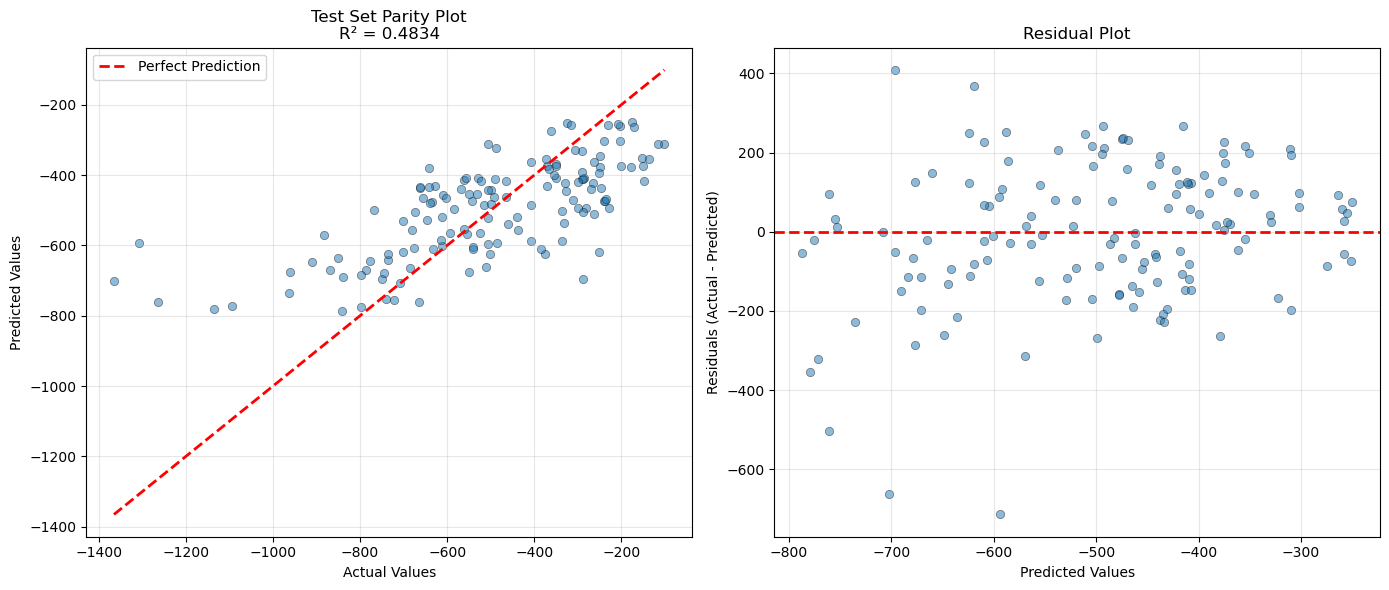

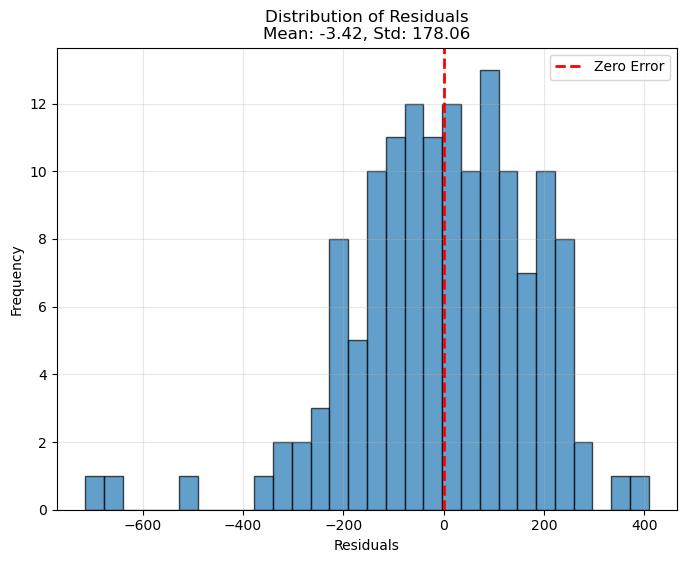

In [49]:
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Make predictions
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)

# Calculate metrics
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("Model Performance Metrics:")
print(f"Training R²: {r2_train:.4f}")
print(f"Test R²: {r2_test:.4f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"\nFor context:")
print(f"Target mean: {y_train.mean():.2f}")
print(f"Target std: {y_train.std():.2f}")

# Create parity plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Test set parity plot
axes[0].scatter(y_test, y_pred_test, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title(f'Test Set Parity Plot\nR² = {r2_test:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test - y_pred_test
axes[1].scatter(y_pred_test, residuals, alpha=0.5, edgecolors='k', linewidth=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution of residuals
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
ax.set_title(f'Distribution of Residuals\nMean: {residuals.mean():.2f}, Std: {residuals.std():.2f}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

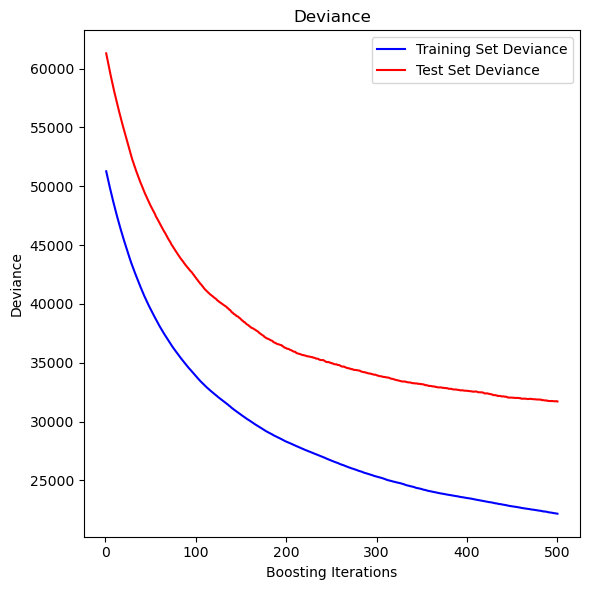

In [50]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)

for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance"
)

plt.plot(
    np.arange(params["n_estimators"]) + 1,
    test_score, "r-", label="Test Set Deviance"
)

plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

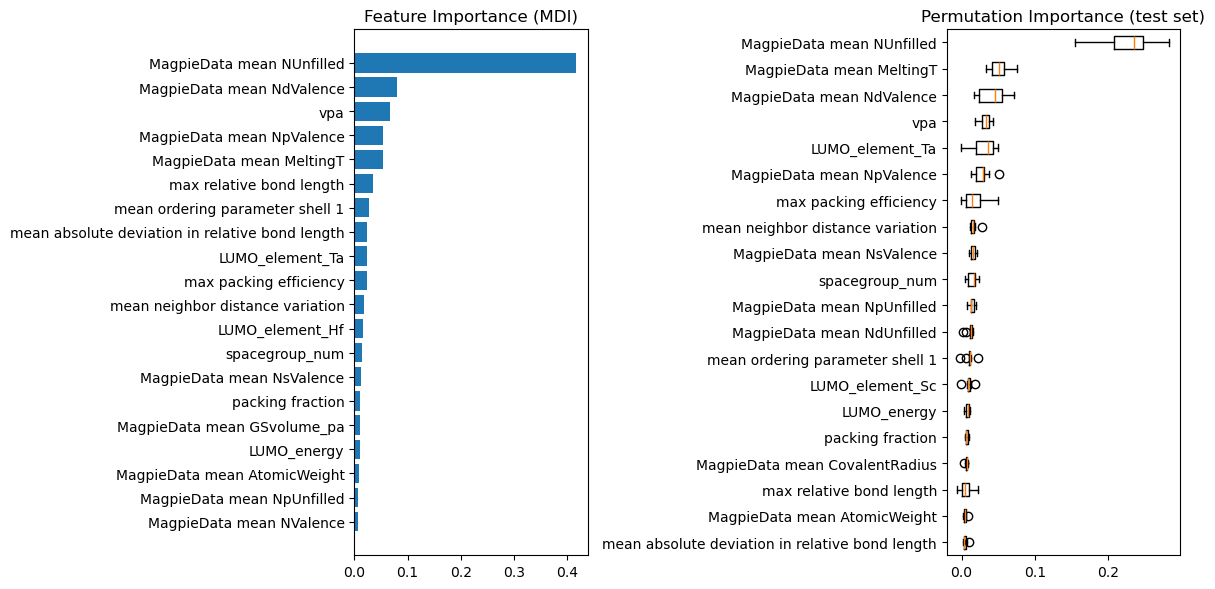

In [51]:
# Feature importance plots
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
feature_names = h_X.columns.tolist()

pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Show only top 20 features
top_n = 20
sorted_idx_top = sorted_idx[-top_n:]  # Get top 20
pos = np.arange(top_n) + 0.5
plt.barh(pos, feature_importance[sorted_idx_top], align="center")
plt.yticks(pos, np.array(feature_names)[sorted_idx_top])
plt.title("Feature Importance (MDI)")

# Permutation importance
result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_idx = result.importances_mean.argsort()
sorted_idx_top = sorted_idx[-top_n:]

plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx_top].T, 
    vert=False, 
    tick_labels=np.array(feature_names)[sorted_idx_top]
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()